Solves the Kuramoto-Sivashinsky equation
\begin{equation}
u_t +uu_x= -d u_{xx}-\nu u_{xxxx}
\end{equation}
in Fourier space using ApproxFun.jl and DifferentialEquations.jl. The negative diffusivity and hyperviscosity can be compared to find the diffusive cutoff scale. Typically, larger the $d$ or smaller the $\nu$, more number of unstable modes manifest.

Currently numerically unstable for $\nu$=0.2 and $d$<0.02. It should be stable for All values of $d$ and $\nu$ for sufficiently small values of $dt$. One check is that the ApproxFun derivatives are correct, especially for high wavenumbers.

In [4]:
using DifferentialEquations
using ApproxFun, Sundials
using PyPlot

In [5]:
#using Pkg
#Pkg.add("DiffEqOperators")
using DiffEqOperators, LinearAlgebra

In [8]:
S = Fourier()
#S = Chebyshev()
n = 2^8
x = points(S, n)
T = ApproxFun.plan_transform(S, n)
Ti = ApproxFun.plan_itransform(S, n)

d = 0.2
nu = 2e-2
dt = 1e-3
Nmax =  (3000+1)
t0 = Nmax * dt

u₀ = T*(cos.(x).*(sin.(x).+1));

In [9]:

# D1 = Derivative(S,1)
# D2 = Derivative(S,2)
# D4 = Derivative(S,4)
# L1 = D1[1:n,1:n];
# L2 = D2[1:n,1:n];
# L4 = D4[1:n,1:n];


In [10]:
function d_dx(S, n, N)
    D = Derivative(S,n)
    return D[1:N,1:N]    
end    

d_dx (generic function with 1 method)

In [11]:
Dx(S,m) = d_dx(S,m,n)
L1 = Dx(S,1)
L2 = Dx(S,2)
L4 = Dx(S,4)

256×256 BandedMatrices.BandedMatrix{Float64,Array{Float64,2},Base.OneTo{Int64}}:
 0.0   ⋅    ⋅     ⋅     ⋅     ⋅     ⋅   …   ⋅          ⋅          ⋅ 
  ⋅   1.0   ⋅     ⋅     ⋅     ⋅     ⋅       ⋅          ⋅          ⋅ 
  ⋅    ⋅   1.0    ⋅     ⋅     ⋅     ⋅       ⋅          ⋅          ⋅ 
  ⋅    ⋅    ⋅   16.0    ⋅     ⋅     ⋅       ⋅          ⋅          ⋅ 
  ⋅    ⋅    ⋅     ⋅   16.0    ⋅     ⋅       ⋅          ⋅          ⋅ 
  ⋅    ⋅    ⋅     ⋅     ⋅   81.0    ⋅   …   ⋅          ⋅          ⋅ 
  ⋅    ⋅    ⋅     ⋅     ⋅     ⋅   81.0      ⋅          ⋅          ⋅ 
  ⋅    ⋅    ⋅     ⋅     ⋅     ⋅     ⋅       ⋅          ⋅          ⋅ 
  ⋅    ⋅    ⋅     ⋅     ⋅     ⋅     ⋅       ⋅          ⋅          ⋅ 
  ⋅    ⋅    ⋅     ⋅     ⋅     ⋅     ⋅       ⋅          ⋅          ⋅ 
  ⋅    ⋅    ⋅     ⋅     ⋅     ⋅     ⋅   …   ⋅          ⋅          ⋅ 
  ⋅    ⋅    ⋅     ⋅     ⋅     ⋅     ⋅       ⋅          ⋅          ⋅ 
  ⋅    ⋅    ⋅     ⋅     ⋅     ⋅     ⋅       ⋅          ⋅          ⋅ 
 ⋮                    

In [12]:
A = DiffEqArrayOperator(-d*Diagonal(L2)-nu*Diagonal(L4))

DiffEqArrayOperator{Float64,Diagonal{Float64,Array{Float64,1}},typeof(DiffEqBase.DEFAULT_UPDATE_FUNC)}([-0.0 0.0 … 0.0 0.0; 0.0 0.18000000000000002 … 0.0 0.0; … ; 0.0 0.0 … -5.1996670200000005e6 0.0; 0.0 0.0 … 0.0 -5.36543232e6], DiffEqBase.DEFAULT_UPDATE_FUNC)

In [17]:
function f(dû,û,tmp,t)
  # Transform u back to point-space
  mul!(tmp,Ti,û)
  tmp= 0.5.*tmp.*tmp
  mul!(tmp, T, tmp)
  mul!(dû,-L1,tmp)    
  #mul!(dû,T,tmp) # Transform back to Fourier space
end

f (generic function with 1 method)

In [18]:
prob = SplitODEProblem(A, f, u₀, (0.0,t0), similar(u₀));

In [19]:
sol = solve(prob, ETDRK4(), dt=dt)

retcode: Success
Interpolation: 3rd order Hermite
t: 3004-element Array{Float64,1}:
 0.0
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009000000000000001
 0.010000000000000002
 0.011000000000000003
 0.012000000000000004
 ⋮
 2.9919999999997815
 2.9929999999997814
 2.9939999999997813
 2.994999999999781
 2.995999999999781
 2.996999999999781
 2.997999999999781
 2.9989999999997807
 2.9999999999997806
 3.0009999999997805
 3.0019999999997804
 3.001
u: 3004-element Array{Array{Float64,1},1}:
 [-5.2512003524312095e-17, 9.412373427195134e-17, 1.0, 0.5, -1.0285899315265006e-16, 5.872110630286023e-17, -1.931231632089504e-17, 6.099563844139619e-17, 3.49507587983103e-18, 3.0041826889091146e-17  …  -3.2246697248208723e-17, -6.197698520320395e-18, -1.4326908838472506e-17, -5.003201408188741e-18, -5.235528008911165e-18, -0.0, -8.316563711914074e-18, 2.1534186447614525e-18, 0.0, 7.571823474787936e-18]
 [-5.2590274950011845e-17, 9.414067806901627e-17, 1.000680088840932, 0.4999898837913804, -

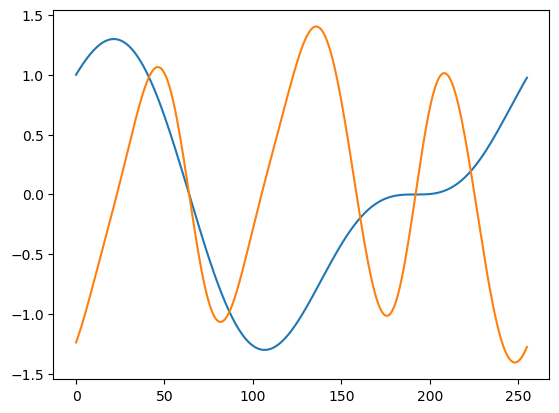

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f40f426fe90>

In [20]:
plot(Ti*sol(0.001))
plot(Ti*sol(3))
#plot(Ti*sol(3))


In [22]:
#
u = zeros(eltype(sol),(n, Nmax))
for it in 1:Nmax
   print(dt*it)
   u[:,it] = Ti*sol(dt*it)
   #println(u[:,it]) 
end
size(u)

0.0010.0020.0030.0040.0050.0060.0070.0080.0090000000000000010.010.0110.0120.0130000000000000010.0140.0150.0160.0170.0180000000000000020.0190.020.0210.0220.0230.0240.0250.0260000000000000020.0270.0280.0290.030.0310.0320.0330.0340.0350.0360000000000000040.0370.0380.0390.040.0410.0420.0430000000000000030.0440.0450.0460.0470.0480.0490.050.0510000000000000040.0520000000000000050.0530.0540.0550.0560.0570.0580.0590000000000000040.060.0610.0620.0630.0640.0650.0660.0670.0680.0690.070.071000000000000010.072000000000000010.0730.0740.0750.0760.0770.0780.0790.080.0810.0820.0830.0840.0850.086000000000000010.087000000000000010.0880.0890.090.0910.0920.0930.0940.0950.0960.0970.0980.0990.10.1010.102000000000000010.103000000000000010.104000000000000010.1050.1060.1070.1080.1090.110.1110.1120.1130.1140.1150.1160.1170.118000000000000010.119000000000000010.120.1210.1220.1230.1240.1250.1260.1270.1280.1290.130.1310.1320.1330.1340.1350.1360.1370.1380.1390.140.141000000000000010.142000000000000020.14300000000000

1.51900000000000011.521.52100000000000011.5221.52300000000000011.5241.52500000000000011.5261.52700000000000011.5281.52900000000000011.531.53100000000000011.5321.53300000000000011.5341.53500000000000011.5361.5371.5381.5391.541.5411.5421.5431.5441.5451.5461.5471.5481.5491.551.5511.5521.5531.5541.5551.5561.5571.5581.5591.561.5611.5621.5631.5641.5651.5661.5671.5681.5691.571.5711.5721.5731.5741.5751.5761.5771.5781.5791.581.5811.5821.5831.5841.5851.5861.5871.5881.5891.591.5911.5921.5931.5941.5951.5961.5971.5981.5991.61.6011.6021.6031.6041.6051.6061.6071.6081.6091.611.6111.6121.6131.6141.6151.6161.6171.6181.6191.621.6211.6221.6231.6241.6251.62600000000000011.6271.62800000000000011.6291.63000000000000011.6311.63200000000000011.6331.63400000000000011.6351.63600000000000011.6371.63800000000000011.6391.64000000000000011.6411.64200000000000011.6431.64400000000000011.6451.64600000000000011.6471.64800000000000011.6491.65000000000000011.6511.65200000000000011.6531.65400000000000011.6551.6560000000000

(256, 3001)

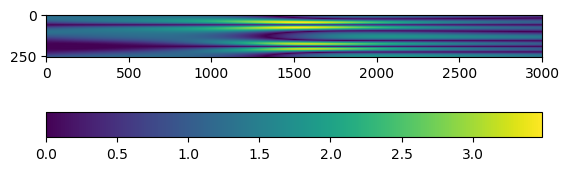

PyObject <matplotlib.colorbar.Colorbar object at 0x7f406bca3f90>

In [23]:

IM = PyPlot.imshow(abs.(u))
cb = PyPlot.colorbar(IM, orientation="horizontal") 
#gcf()